In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv1D, Flatten, Dense, Dropout

def cosine_distance_loss(y_true, y_pred):

    y_true_norm = tf.nn.l2_normalize(y_true, axis=1)
    y_pred_norm = tf.nn.l2_normalize(y_pred, axis=1)

    # Iloczyn skalarny (Cosine Similarity)
    # Wynik jest od -1 (przeciwne) do 1 (zgodne)
    cosine_similarity = tf.reduce_sum(y_true_norm * y_pred_norm, axis=1)

    # Chcemy minimalizowac strate
    # Kąt 0 st -> cos = 1. Chcemy żeby loss był 0.
    # Loss = 1 - cos
    return 1 - cosine_similarity


PRZETWARZANIE KLASY: Class A (Anti-Elec CC) (atm_neutrino_classA.h5)
Trenowanie modelu...
Epoch 1/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.5835 - mae: 0.4415 - val_loss: 0.2362 - val_mae: 0.3297
Epoch 2/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2672 - mae: 0.3307 - val_loss: 0.2302 - val_mae: 0.3067
Epoch 3/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2562 - mae: 0.3165 - val_loss: 0.2305 - val_mae: 0.2998
Epoch 4/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2534 - mae: 0.3113 - val_loss: 0.2298 - val_mae: 0.2977
Epoch 5/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2491 - mae: 0.3049 - val_loss: 0.2313 - val_mae: 0.2981
Epoch 6/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2430 - mae: 0.3063 - val_loss: 0.2302 - val_mae: 0.2954
Epoch 7/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2484 - mae: 0.3079 - val_loss: 0.2296 - val_mae: 0.2948
Epoch 8/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2504 - mae: 0.3054 - val_loss: 0.2292

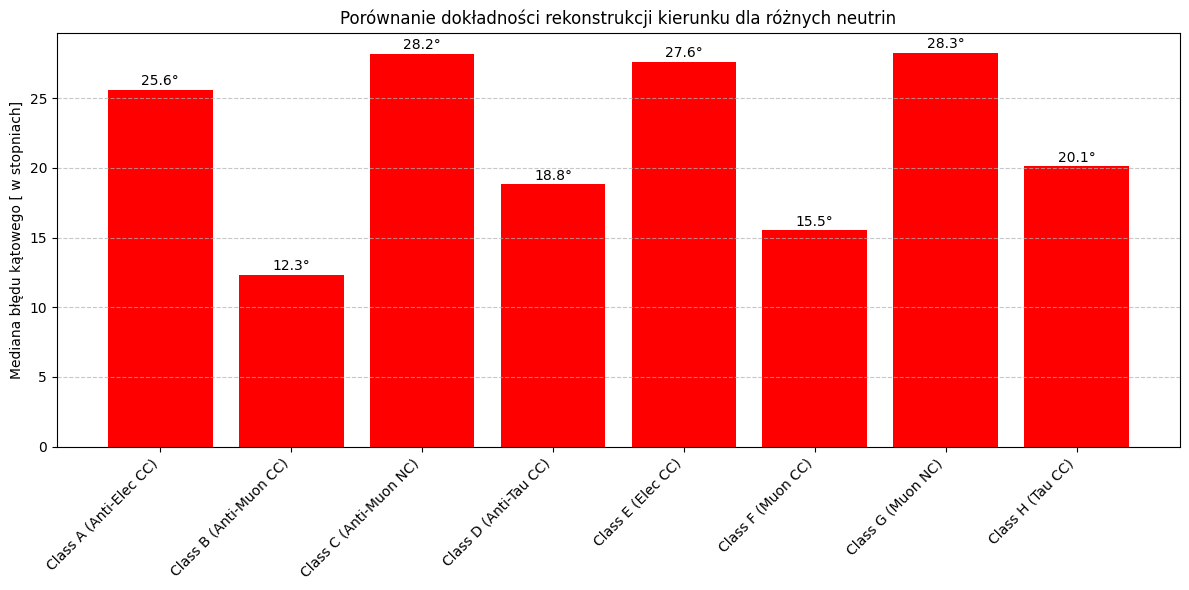

In [14]:
#===========================================================================
#Definicja Funkcji Trenującej


def train_and_evaluate(file_name, class_label):
    print(f"\n{'='*40}")
    print(f"PRZETWARZANIE KLASY: {class_label} ({file_name})")
    print(f"{'='*40}")

    # Wczytanie danych
    try:
        df = pd.read_hdf(file_name, key='y')
    except FileNotFoundError:
        return None

    initial_len = len(df)
    df = df.dropna()
    final_len = len(df)

    if final_len < initial_len:
        print(f"Usunięto wierszy : {initial_len - final_len}")

    if final_len == 0:
        return None
    # ==========================================

    # Wybór kolumn
    input_dir_cols = ['jmuon_dir_x', 'jmuon_dir_y', 'jmuon_dir_z', 'jmuon_likelihood']
    target_dir_cols = ['dir_x', 'dir_y', 'dir_z']

    X_dir = df[input_dir_cols].values
    y_dir = df[target_dir_cols].values

    # Podział
    X_train, X_test, y_train, y_test = train_test_split(
        X_dir, y_dir, test_size=0.2, random_state=42
    )

    # Skalowanie
    scaler_dir = StandardScaler()
    X_train_scaled = scaler_dir.fit_transform(X_train)
    X_test_scaled = scaler_dir.transform(X_test)

    # Reshape dla CNN
    X_train_cnn = X_train_scaled.reshape(X_train_scaled.shape[0], 4, 1)
    X_test_cnn = X_test_scaled.reshape(X_test_scaled.shape[0], 4, 1)

    #Budowa Modelu CNN
    model = Sequential()
    model.add(Input(shape=(4, 1)))
    model.add(Conv1D(filters=32, kernel_size=2, activation='relu'))
    model.add(Flatten())
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(3, activation='linear'))

    model.compile(optimizer='adam', loss=cosine_distance_loss, metrics=['mae'])

    #Trening
    print("Trenowanie modelu...")
    history = model.fit(
        X_train_cnn, y_train,
        epochs=20,
        batch_size=64,
        validation_split=0.2,
        verbose=1 #moze byc 0
    )

    # 8. Ewaluacja
    y_pred = model.predict(X_test_cnn, verbose=0)

    # Obliczanie kąta z zabezpieczeniem przed dzieleniem przez zero
    def get_angle(v1, v2):
        # Dodaje sie 'epsilon' (1e-8) zeby nie dzielic przez zero
        epsilon = 1e-8
        norm_v1 = np.linalg.norm(v1, axis=1, keepdims=True) + epsilon
        norm_v2 = np.linalg.norm(v2, axis=1, keepdims=True) + epsilon

        v1_n = v1 / norm_v1
        v2_n = v2 / norm_v2

        dot = np.sum(v1_n * v2_n, axis=1)
        dot = np.clip(dot, -1.0, 1.0)
        return np.degrees(np.arccos(dot))

    angles = get_angle(y_test, y_pred)
    #ewentualne nan z wyniku zostana wyrzuocne ( w razie czego)
    angles = angles[~np.isnan(angles)]

    if len(angles) == 0:
        median_error = np.nan
    else:
        median_error = np.median(angles)

    print(f"Mediana błędu kątowego: {median_error:.2f} stopni")
    return median_error, history

# ==============================================================================
#Pętla po wszystkich plikach

files_map = {
    'Class A (Anti-Elec CC)': 'atm_neutrino_classA.h5',
    'Class B (Anti-Muon CC)': 'atm_neutrino_classB.h5',
    'Class C (Anti-Muon NC)': 'atm_neutrino_classC.h5',
    'Class D (Anti-Tau CC)':  'atm_neutrino_classD.h5',
    'Class E (Elec CC)':      'atm_neutrino_classE.h5',
    'Class F (Muon CC)':      'atm_neutrino_classF.h5',
    'Class G (Muon NC)':      'atm_neutrino_classG.h5',
    'Class H (Tau CC)':       'atm_neutrino_classH.h5',
}

results = {}
histories = {} ##robimy slownik do przechownaia historii uczenia

for label, filename in files_map.items():
    result_tuple = train_and_evaluate(filename, label)
    if metric is not None:
        metric, hist = result_tuple
        results[label] = metric
        histories[label] = hist

# ==============================================================================
#Wizualizacja Porównania


if results:
    for cls, err in results.items():
        print(f"{cls}: {err:.2f}°")

    plt.figure(figsize=(12, 6))
    names = list(results.keys())
    values = list(results.values())

    bars = plt.bar(names, values, color='red')

    plt.ylabel('Mediana błędu kątowego [ w stopniach]')
    plt.title('Porównanie dokładności rekonstrukcji kierunku dla różnych neutrin')
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Dodanie liczb nad słupkami
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval + 0.1, f'{yval:.1f}°', ha='center', va='bottom')

    plt.tight_layout()
    plt.show()
else:
    print("Err2")

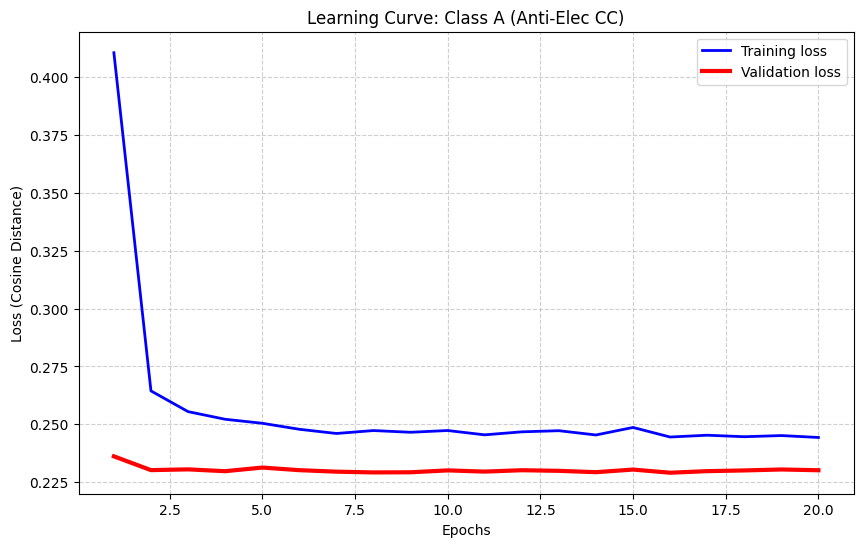

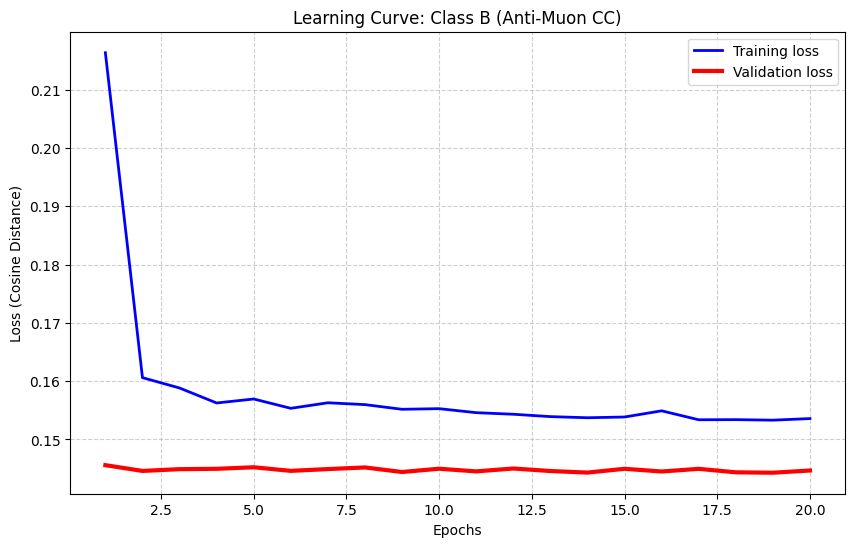

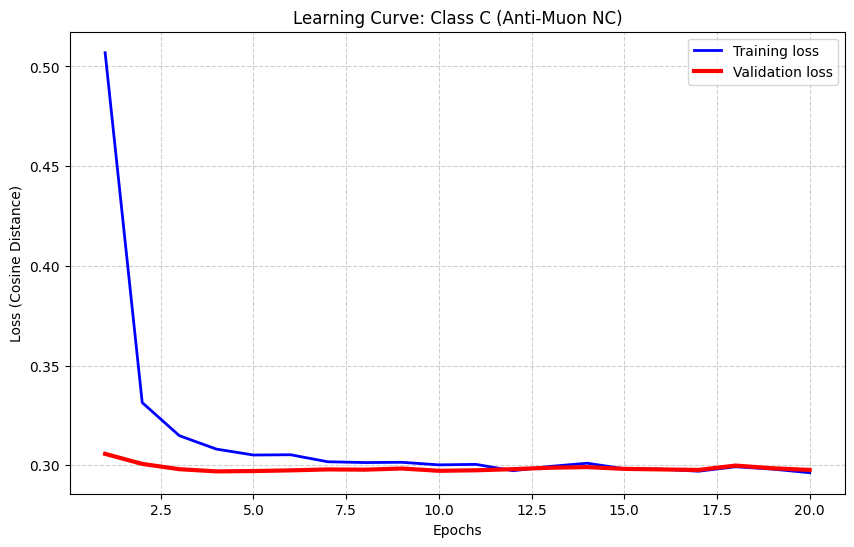

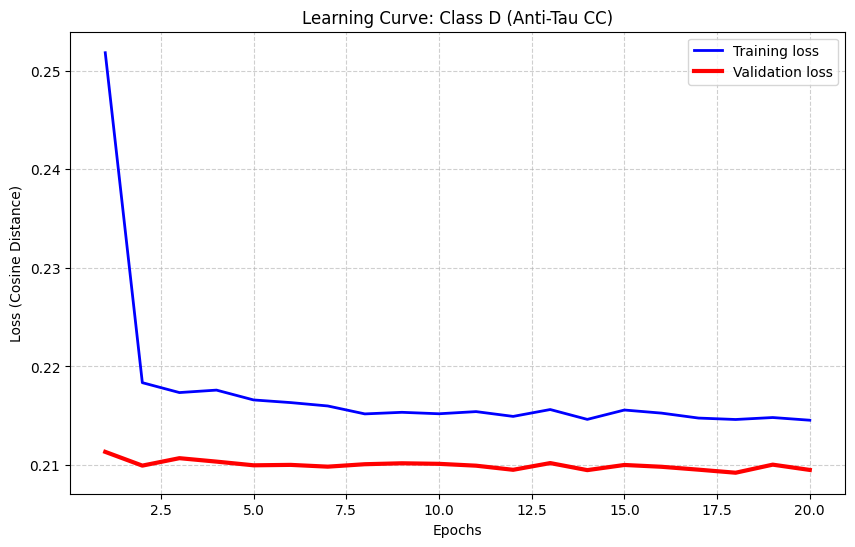

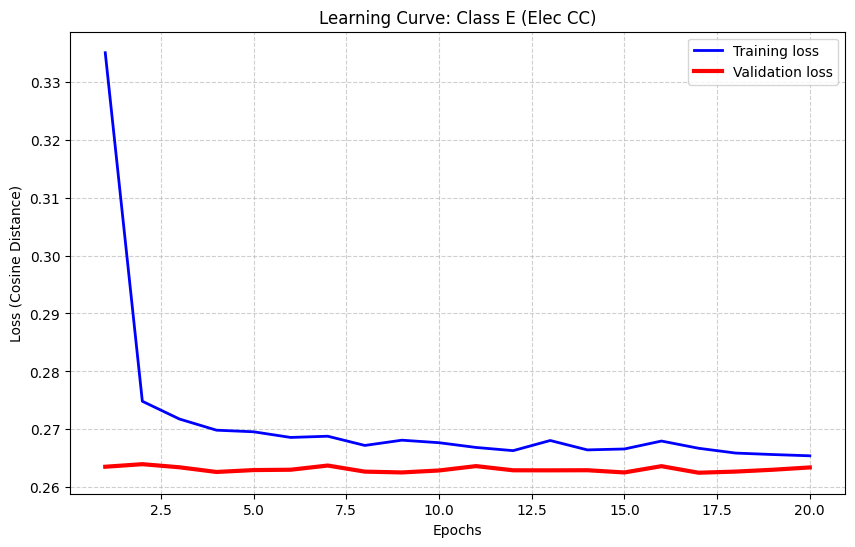

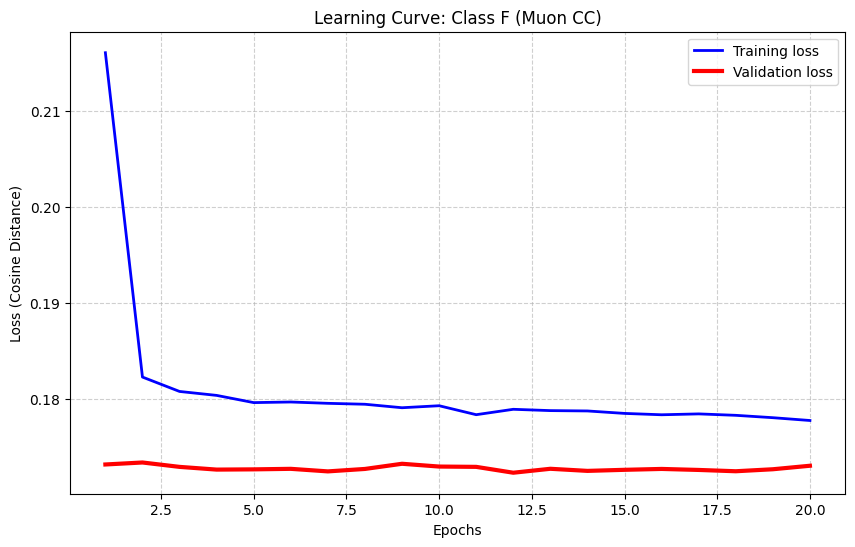

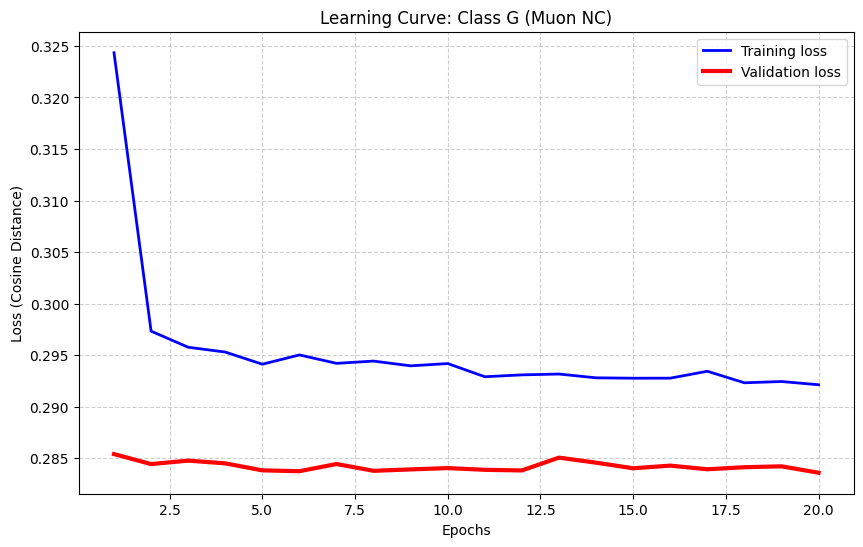

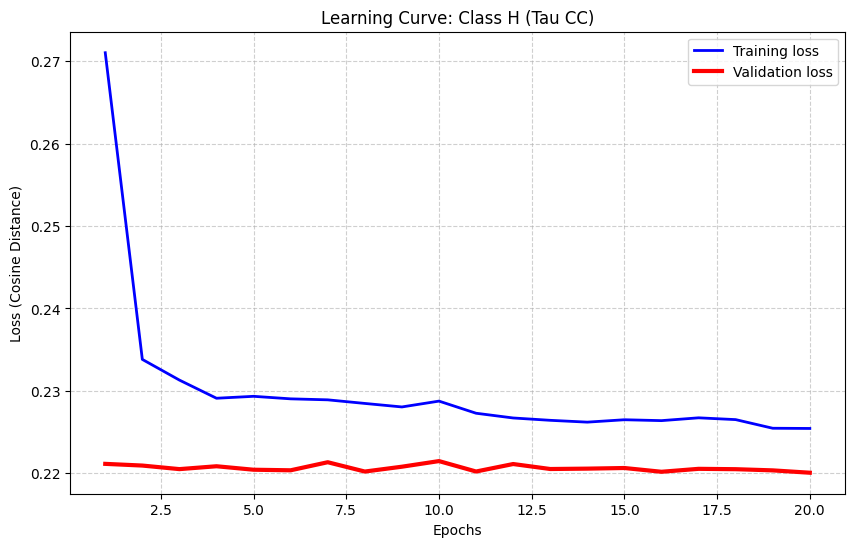

In [15]:
if histories:
    # Pętla po wszystkich zapisanych historiach
    for class_label, history_obj in histories.items():


        loss = history_obj.history['loss']
        val_loss = history_obj.history['val_loss']
        epochs_range = range(1, len(loss) + 1)


        plt.figure(figsize=(10, 6))
        plt.plot(epochs_range, loss, 'b-', linewidth=2, label='Training loss')
        plt.plot(epochs_range, val_loss, 'r-', linewidth=3, label='Validation loss')


        plt.title(f'Learning Curve: {class_label}')
        plt.xlabel('Epochs')
        plt.ylabel('Loss (Cosine Distance)')
        plt.legend(loc='upper right')
        plt.grid(True, which='both', linestyle='--', alpha=0.6)


        plt.show()

else:
    sys.exit(1)